<a href="https://colab.research.google.com/github/geraldomsousaj/industrial-challenge-EDF/blob/importanceFactor/final_industrial_challenge_EDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Industrial Challenge EDF**

Authors: Bruna VICENTE, Geraldo MARQUES, Theo MAES, Yuichi TOKUMOTO

In [ ]:
!pip install openturns
import openturns as ot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import warnings
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.optimize import curve_fit
from numpy import arange
from scipy.optimize import minimize, LinearConstraint, Bounds

# 0. Context
The following risk situation is studied: 
- an industrial facility is located along a river, 
- the flood flow (of random flow Q) can cause a significant height of water H, which could flood the 
installation  if  the  level  reached  during  a  flood  event  ($Z_{c}$)  overflows  over  the  protective  dike 
(assumed to be established at $Z_{d}$), 
- the extent of the damage then caused in the installation depends on the vulnerability of the site 
at the time of the hypothetical spill. 

# 1. First Approach: Determination of the dike height from historical data



## 1.1. Load historical data

In [ ]:
url = 'https://github.com/geraldomsousaj/industrial-challenge-EDF/blob/importanceFactor/Donn%C3%A9es-projet-EDF_2018-2019.xls?raw=true'
df = pd.read_excel(url)
df.columns = ['year', 'flow_Q', 'height_H']

In [ ]:
df.head()

,year,flow_Q,height_H
0,1849,3853.892756,NaN
1,1850,1256.402143,4.0
2,1851,1648.542191,4.5
3,1852,1604.857094,4.3
4,1853,341.157419,1.7


## 1.2. Fit a distribution to the historical data

In [ ]:
data = np.log(df['height_H'])
data.interpolate('linear', limit_direction="both")
data = np.exp(data.interpolate('linear', limit_direction="both"))


Fitting a distribution:

Apply `scipy` method `fit` to fit a distribution among the ones available. 
- Compute the maximum likelihood estimator of distribution parameters, including location (`loc`) and (`scale`);
- Calculate fitted PDF and error with fit in distribution;
- Compare the SSE (Error Sum of Squares);

Error Sum of Squares: 

$\sum_{i=1}^n (x_{i}-\bar{x})^2$

The chosen distribution will be the one with the smallest SSE.

(2.4484424851117446, 0.999999621150339, 1.1952278955258429)


Text(0, 0.5, 'Frequency')

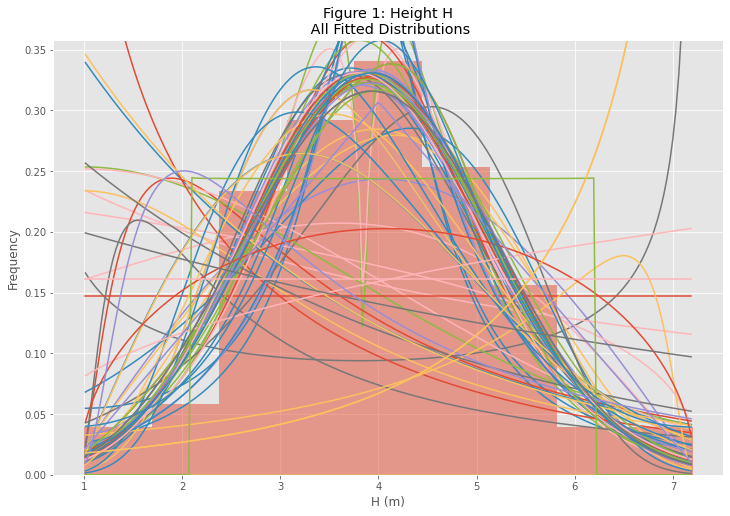

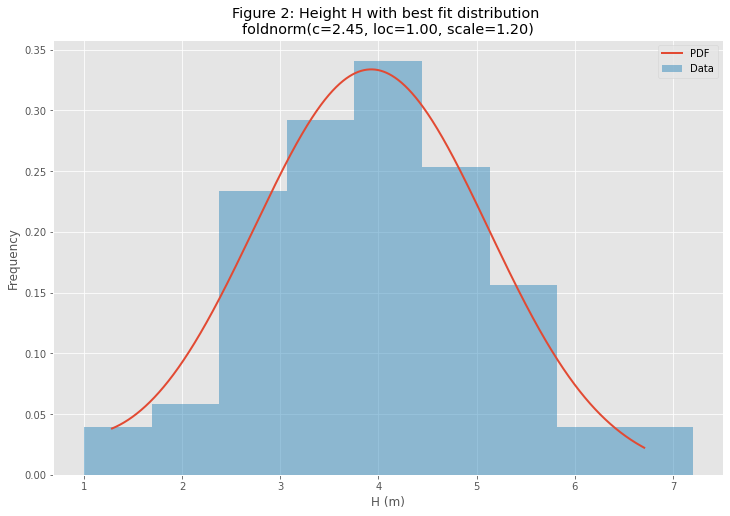

In [ ]:
# fit a distribution
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """
    print(params)
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data 
data = data

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=9, alpha=0.5, density=True)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Figure 1: Height H\n All Fitted Distributions')
ax.set_xlabel(u'H (m)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

weights = np.ones_like(data)/float(len(data))

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=9, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Figure 2: Height H with best fit distribution \n' + dist_str)
ax.set_xlabel(u'H (m)')
ax.set_ylabel('Frequency')

The first plot represents the histogram of our empirical data with all distributions.

The second plot represents the histogram with the distribution with the smallest SSE. For our case, we have a folded normal distribution. 

The probability density function for folded norm distribution is: 

$f(x, c) = \sqrt{\frac{2}{\pi}} cosh(cx)\exp(-\frac{(\frac{x-loc}{scale})^2+c^2}{2})$

Note that shifting the location of a distribution does not make it a “noncentral” distribution; noncentral generalizations of some distributions are available in separate classes.

In our case, we have `scale = 1.20`, `loc = 1.00` and `c = 2.45`.

## 1.3 Computing the risk

In [ ]:
quantile = [0.001, 0.005, 0.01, 0.025, 0.05, .1]
data = []

# Best parameters
scale = best_fit_params[2]
loc = best_fit_params[1]
c = best_fit_params[0]

for q in quantile:
    x = st.foldnorm.ppf(q=1-q, c=c, loc=loc, scale=scale)
    dic = {
        'Quantile (%)': q*100,
        'Height (m)': round(x, 4)
    }
    data.append(dic)

pd.DataFrame(data, columns=dic.keys())

,Quantile (%),Height (m)
0,0.1,7.6200
1,0.5,7.0051
2,1.0,6.7070
3,2.5,6.2691
4,5.0,5.8924
5,10.0,5.4582


In order to fulfill the 1% quantile of the fitted distribution, we need to have:

 $h_{d} = 6.71$m

# 2. Second Approach: Determination of the dike height from the hydraulic model

## 2.1. Running the simulation

In [ ]:
# defining the constants
L = 5000 # length of section (m)
B = 300 # watercourse width (m)
Zb = 55.5 # shoreline elevation (m)

In [ ]:
# Create the marginal distributions of the parameters
dist_Q = ot.TruncatedDistribution(ot.Gumbel(558., 1013.), 0, ot.TruncatedDistribution.LOWER)
dist_Ks = ot.TruncatedDistribution(ot.Normal(30.0, 7.5), 0, ot.TruncatedDistribution.LOWER)
dist_Zv = ot.Triangular(49, 50 , 51)
dist_Zm = ot.Triangular(54, 55 , 56)

In [ ]:
# defining the input vector
X = ot.ComposedDistribution([dist_Q, dist_Ks, dist_Zv, dist_Zm])
inputRV = ot.RandomVector(X)

In [ ]:
# defining the hydraulic model
def function_flood(X):
    """
    Hydraulic model: S = H + Zv - Zb
    here, we firtly set hd=0
    H = (Q/(Ks * B * np.sqrt((Zm - Zv) / L)))** (3.0/5.0) 

    Parameter:
        X : input vector, such that:
            X[0] := Q,
            X[1] := Ks,
            X[2] := Zv,
            X[3] := Zm

    Return: 
        S: type list
    """
    Q, Ks, Zv, Zm = X
    alpha = (Zm - Zv)/L
    H = (Q/(Ks * B * np.sqrt(alpha)))** (3.0/5.0) 
    S = H + Zv - Zb
    return [S]

input_dimension = 4
g = ot.PythonFunction(input_dimension , 1, function_flood)

In [ ]:
# Run 10^6 simulations
N = 10**6
S = []
for i in range(N):
    S.append(function_flood(inputRV.getRealization()))

In [ ]:
S_df = pd.DataFrame(S, columns=['S'])

In [ ]:
def sample_H(N):

  Q = dist_Q.getSample(N)
  Ks = dist_Ks.getSample(N)
  Zv = dist_Zv.getSample(N)
  Zm = dist_Zm.getSample(N)

  Q_rnd =[]
  Ks_rnd =[]
  Zv_rnd =[]
  Zm_rnd =[]
  ZvH_rnd =[]

  for k in range(N):
    Q_rnd.append(Q[k][0])
    Ks_rnd.append(Ks[k][0])
    Zv_rnd.append(Zv[k][0])
    Zm_rnd.append(Zm[k][0])

  H_rnd =[]
  for k in range(N):
    H = (Q_rnd[k]/(Ks_rnd[k] * B * np.sqrt((Zm_rnd[k]-Zv_rnd[k])/L)))** (3.0/5.0)
    ZvH_rnd.append(H + Zv_rnd[k] - Zb) 
    H_rnd.append(H)

  return H_rnd, Q_rnd, Ks_rnd, Zv_rnd, Zm_rnd, ZvH_rnd

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



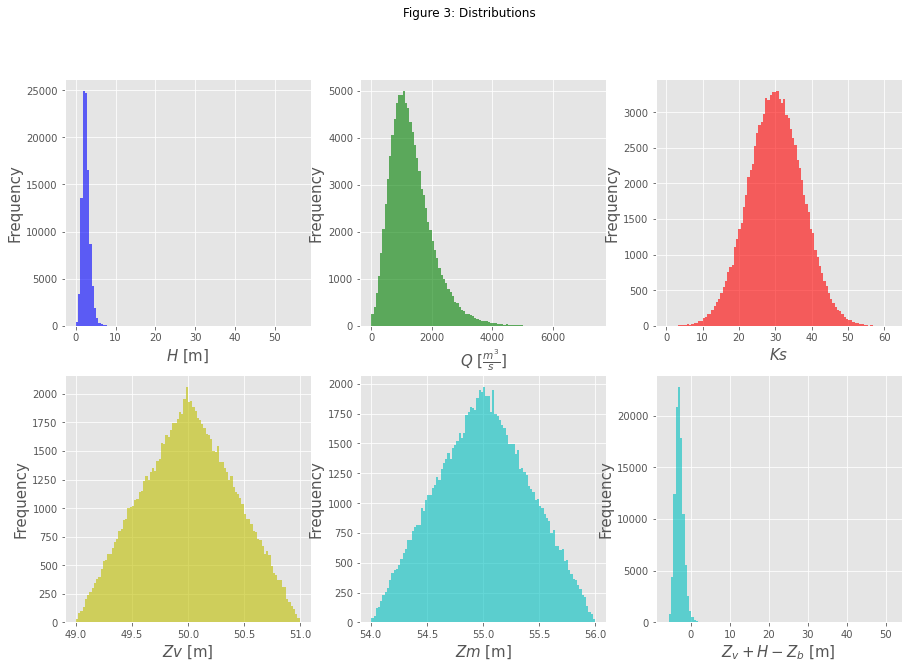

In [ ]:
msize = 10**5
binsize = 100
Histograms = sample_H(msize)
print(Histograms)

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax[0][0].hist(Histograms[0], bins = binsize, facecolor='b', alpha=0.6)
ax[0][0].set_xlabel('$H$ [m]',fontsize=15)
ax[0][0].set_ylabel('Frequency',fontsize=15)

ax[0][1].hist(Histograms[1], bins = binsize, facecolor='g', alpha=0.6)
ax[0][1].set_xlabel(r'$Q$ [$\frac{m^3}{s}$]',fontsize=15)
ax[0][1].set_ylabel('Frequency',fontsize=15)

ax[0][2].hist(Histograms[2], bins = binsize, facecolor='r', alpha=0.6)
ax[0][2].set_xlabel(r'$Ks$',fontsize=15)
ax[0][2].set_ylabel('Frequency',fontsize=15)

ax[1][0].hist(Histograms[3], bins = binsize, facecolor='y', alpha=0.6)
ax[1][0].set_xlabel(r'$Zv$ [m]',fontsize=15)
ax[1][0].set_ylabel('Frequency',fontsize=15)

ax[1][1].hist(Histograms[4], bins = binsize, facecolor='c', alpha=0.6)
ax[1][1].set_xlabel(r'$Zm$ [m]',fontsize=15)
ax[1][1].set_ylabel('Frequency',fontsize=15)

ax[1][2].hist(Histograms[5], bins = binsize, facecolor='c', alpha=0.6)
ax[1][2].set_xlabel(r'$Z_v + H - Z_b$ [m]',fontsize=15)
ax[1][2].set_ylabel('Frequency',fontsize=15)

fig.suptitle('Figure 3: Distributions') 

plt.show()

## 2.2. Analysing confidence intervals

To analyse the hydraulic model, we ran 100 batches, varying the number of simulations per batch, the values tested being: $10^3$, $10^4$, $10^5$ and $10^6$.

Thus we generated a dataframe with the quantiles for each batch available at this [link](https://raw.githubusercontent.com/geraldomsousaj/industrial-challenge-EDF/importanceFactor/confidence_interval_simulations.csv).

We will import this dataframe and analyse it.

Rk: the column `batch` represents the # of the batch, the column `N` represents the number of simulations, the column `q` represents the quantile calculated, the column `positive` represents if only positive values of the simulation were used to compute quantiles (if True -> only positive values, else False -> the whole dataframe) and `value` represents the value of the quantile.

In [ ]:
url = 'https://raw.githubusercontent.com/geraldomsousaj/industrial-challenge-EDF/importanceFactor/confidence_interval_simulations.csv'
df = pd.read_csv(url)
df.head()

,batch,N,q,positive,value
0,1,1000,0.950,False,-1.204464
1,1,1000,0.970,False,-0.647725
2,1,1000,0.990,False,0.233622
3,1,1000,0.995,False,0.842226
4,1,1000,0.950,True,1.868197


## 2.3. Study of the uncertainty on the quantiles

After having noticed a marked difference between the quantiles obtained with the 1st and 2nd approach, we decided to study the uncertainty on the quantiles obtained with the physical model. We also took the opportunity to test the robustness of our simulation and to ensure that the number of values chosen was sufficient. For this we simulated, for each sample size ($10^3$,$10^4$ ,$10^5$ and $10^6$) 100 times the overflow values. We then had at our disposal for each sample size 100 different datasets for which we calculated the corresponding quantiles. Our objective was to calculate the 95% confidence interval on the quantiles and to compare how these intervals varied with the sample size. 

Our study is divided in 2, first we have done this work on all the data, then only on the data of positive overflow to focus more precisely on the case where the dyke is necessary.

In [ ]:
dfp=df[df['positive']==True]
dfn=df[df['positive']==False]

dfn3=dfn[dfn['N']==1000]
dfn4=dfn[dfn['N']==10000]
dfn5=dfn[dfn['N']==100000]
dfn6=dfn[dfn['N']==1000000]

dfp3=dfp[dfp['N']==1000]
dfp4=dfp[dfp['N']==10000]
dfp5=dfp[dfp['N']==100000]
dfp6=dfp[dfp['N']==1000000]

dfn3_95=dfn3[dfn3['q']==0.95]
dfn4_95=dfn4[dfn4['q']==0.95]
dfn5_95=dfn5[dfn5['q']==0.95]
dfn6_95=dfn6[dfn6['q']==0.95]

dfn3_99=dfn3[dfn3['q']==0.99]
dfn4_99=dfn4[dfn4['q']==0.99]
dfn5_99=dfn5[dfn5['q']==0.99]
dfn6_99=dfn6[dfn6['q']==0.99]

dfp3_95=dfp3[dfp3['q']==0.95]
dfp4_95=dfp4[dfp4['q']==0.95]
dfp5_95=dfp5[dfp5['q']==0.95]
dfp6_95=dfp6[dfp6['q']==0.95]

dfp3_99=dfp3[dfp3['q']==0.99]
dfp4_99=dfp4[dfp4['q']==0.99]
dfp5_99=dfp5[dfp5['q']==0.99]
dfp6_99=dfp6[dfp6['q']==0.99]

Here are our results and the different confidence intervals found for the quantiles:

**Table 1: 95% confidence interval (All data)**

Sample Size  | Quantile 95% | Quantile 99%
-|-|-
$10^3$      | [-1.109 , -1.069] | [0.023 , 0.115]      
$10^4$ | [-1.082 , -1.069] | [0.105, 0.134]  
$10^5$    | [ -1,077 , -1.072] | [0.120 , 0 .130]
$10^6$  | [-1.077 , -1.076] | [0.123 , 0.127]  

The results of the first table allow us to confirm that the risk of overflow is about 1%. We can now say that this result is reliable because it does not depend on a single simulation, the confidence interval assures us that in 95% of the cases the quantile 0.99 will be between [0.123,0.127] (for the simulation of size $10^6$). In other words, we can be 95% sure that by building a 0.127m dike we avoid 99% of the risk of overflow. But theses confidence interval cannot explain the gap between the result of first and second approach, we can postulade that this gap could come from the lack of data in the first approach and also the simplicity of the model given in the second approach.

In [ ]:
delta6_99n= 2*np.sqrt(sum ((dfn6_99['value']- dfn6_99['value'].mean())**2)/(100*99))
delta6_95n= 2*np.sqrt(sum ((dfn6_95['value']- dfn6_95['value'].mean())**2)/(100*99))
delta3_95n= 2*np.sqrt(sum ((dfn3_95['value']- dfn3_95['value'].mean())**2)/(100*99))
delta3_99n= 2*np.sqrt(sum ((dfn3_99['value']- dfn3_99['value'].mean())**2)/(100*99))
delta4_99n= 2*np.sqrt(sum ((dfn4_99['value']- dfn4_99['value'].mean())**2)/(100*99))
delta4_95n= 2*np.sqrt(sum ((dfn4_95['value']- dfn4_95['value'].mean())**2)/(100*99))
delta5_99n= 2*np.sqrt(sum ((dfn5_99['value']- dfn5_99['value'].mean())**2)/(100*99))
delta5_95n= 2*np.sqrt(sum ((dfn5_95['value']- dfn5_95['value'].mean())**2)/(100*99))

Ci6_99n =(dfn6_99['value'].mean()-delta6_99n, dfn6_99['value'].mean()+delta6_99n)
Ci5_99n =(dfn5_99['value'].mean()-delta5_99n, dfn5_99['value'].mean()+delta5_99n)
Ci4_99n =(dfn4_99['value'].mean()-delta4_99n, dfn4_99['value'].mean()+delta4_99n)
Ci3_99n =(dfn3_99['value'].mean()-delta3_99n, dfn3_99['value'].mean()+delta3_99n)
Ci6_95n =(dfn6_95['value'].mean()-delta6_95n, dfn6_95['value'].mean()+delta6_95n)
Ci5_95n =(dfn5_95['value'].mean()-delta5_95n, dfn5_95['value'].mean()+delta5_95n)
Ci4_95n =(dfn4_95['value'].mean()-delta4_95n, dfn4_95['value'].mean()+delta4_95n)
Ci3_95n =(dfn3_95['value'].mean()-delta3_95n, dfn3_95['value'].mean()+delta3_95n)

print (Ci6_99n,Ci5_99n,Ci4_99n,Ci3_99n,Ci6_95n,Ci5_95n,Ci4_95n,Ci3_95n)


(0.12347621123469683, 0.12627121147632897) (0.12052160202989164, 0.13096020413321283) (0.10501415367875855, 0.1343257485483556) (0.023420655082223414, 0.11604467773715238) (-1.0771976220135744, -1.0760369481547416) (-1.0769492471984388, -1.072815167993981) (-1.0824190075527285, -1.0691672020160197) (-1.104205606167169, -1.0689238753119998)


**Table 2: 95% confidence interval (overflow data only)**

Sample Size  | Quantile 95% | Quantile 99%
-|-|-
$10^3$      | [2.15 , 3.22] |      [2.68 , 2.4.74]
$10^4$ | [2.77 , 3.01] | [5.39 , 7.60]
$10^5$    | [2.89 , 2.97] | [5.96 , 6 .27]
$10^6$  | [2.90 , 2.93] | [6.18 , 6.29]

This second study concerning the positive values of overflow had for goal to refine our knowledge on the risks of great severity. It can be acknowledge, for example, that the statement "95% of the overflows will be avoided with a 2.93 meter dike" is true with a 95% chance (simulation of size $10^6$).



In [ ]:
delta6_99p= 2*np.sqrt(sum ((dfp6_99['value']- dfp6_99['value'].mean())**2)/(100*99))
delta6_95p= 2*np.sqrt(sum ((dfp6_95['value']- dfp6_95['value'].mean())**2)/(100*99))
delta3_95p= 2*np.sqrt(sum ((dfp3_95['value']- dfp3_95['value'].mean())**2)/(100*99))
delta3_99p= 2*np.sqrt(sum ((dfp3_99['value']- dfp3_99['value'].mean())**2)/(100*99))
delta4_99p= 2*np.sqrt(sum ((dfp4_99['value']- dfp4_99['value'].mean())**2)/(100*99))
delta4_95p= 2*np.sqrt(sum ((dfp4_95['value']- dfp4_95['value'].mean())**2)/(100*99))
delta5_99p= 2*np.sqrt(sum ((dfp5_99['value']- dfp5_99['value'].mean())**2)/(100*99))
delta5_95p= 2*np.sqrt(sum ((dfp5_95['value']- dfp5_95['value'].mean())**2)/(100*99))

Ci6_99p =(dfp6_99['value'].mean()-delta6_99p, dfp6_99['value'].mean()+delta6_99p)
Ci5_99p =(dfp5_99['value'].mean()-delta5_99p, dfp5_99['value'].mean()+delta5_99p)
Ci4_99p =(dfp4_99['value'].mean()-delta4_99p, dfp4_99['value'].mean()+delta4_99p)
Ci3_99p =(dfp3_99['value'].mean()-delta3_99p, dfp3_99['value'].mean()+delta3_99p)
Ci6_95p =(dfp6_95['value'].mean()-delta6_95p, dfp6_95['value'].mean()+delta6_95p)
Ci5_95p =(dfp5_95['value'].mean()-delta5_95p, dfp5_95['value'].mean()+delta5_95p)
Ci4_95p =(dfp4_95['value'].mean()-delta4_95p, dfp4_95['value'].mean()+delta4_95p)
Ci3_95p =(dfp3_95['value'].mean()-delta3_95p, dfp3_95['value'].mean()+delta3_95p)

print (Ci6_99p,Ci5_99p,Ci4_99p,Ci3_99p,Ci6_95p,Ci5_95p,Ci4_95p,Ci3_95p)



(6.184631228871597, 6.295344078075962) (5.964163214129713, 6.275515524307173) (5.390149672060902, 7.605861344117907) (2.6716393309292306, 4.749718030044565) (2.908659691249898, 2.9322969777984187) (2.893766341822816, 2.9732337638757547) (2.771250352338984, 3.0106347761573504) (2.142444452394149, 3.224128043769353)


Then we notice, as expected, that the confidence intervals become tighter as the sample size increases, which can be seen in the following two figures:



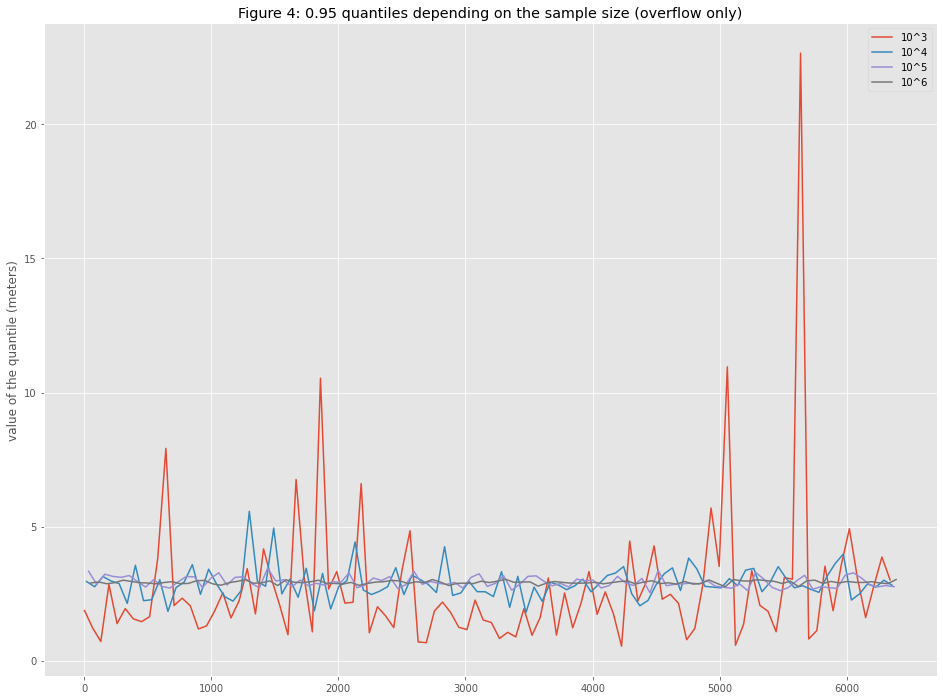

In [ ]:
ax2=dfp3_95['value'].plot(label='10^3')
dfp4_95['value'].plot(label='10^4')
dfp5_95['value'].plot(label='10^5')
dfp6_95['value'].plot(label='10^6')

ax2.set_ylabel('value of the quantile (meters)')
ax2.set_title('Figure 4: 0.95 quantiles depending on the sample size (overflow only)')
ax2.legend()

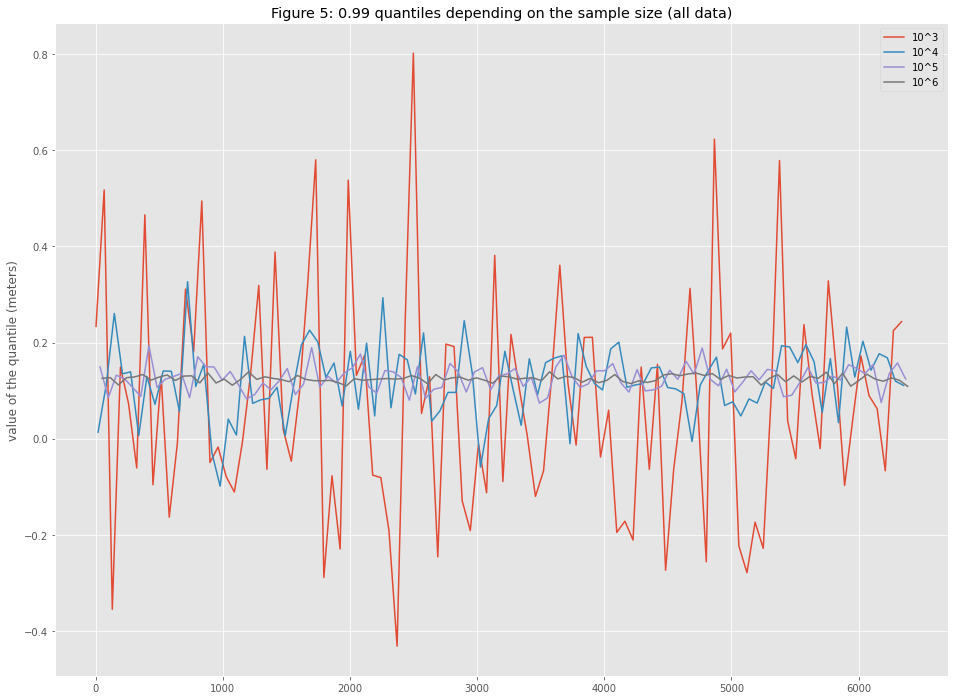

In [ ]:
ax2=dfn3_99['value'].plot(label='10^3')
dfn4_99['value'].plot(label='10^4')
dfn5_99['value'].plot(label='10^5')
dfn6_99['value'].plot(label='10^6')

ax2.set_ylabel('value of the quantile (meters)')
ax2.set_title('Figure 5: 0.99 quantiles depending on the sample size (all data)')
ax2.legend()



The simulation follows the Law of Large Numbers since the value of the quantile tends towards its mean when the sample size tends towards infinity.

As predicted by the Central Limit Theorem, the quantile distribution approaches a normal distribution as the sample size increases, which is visible in the following histograms:


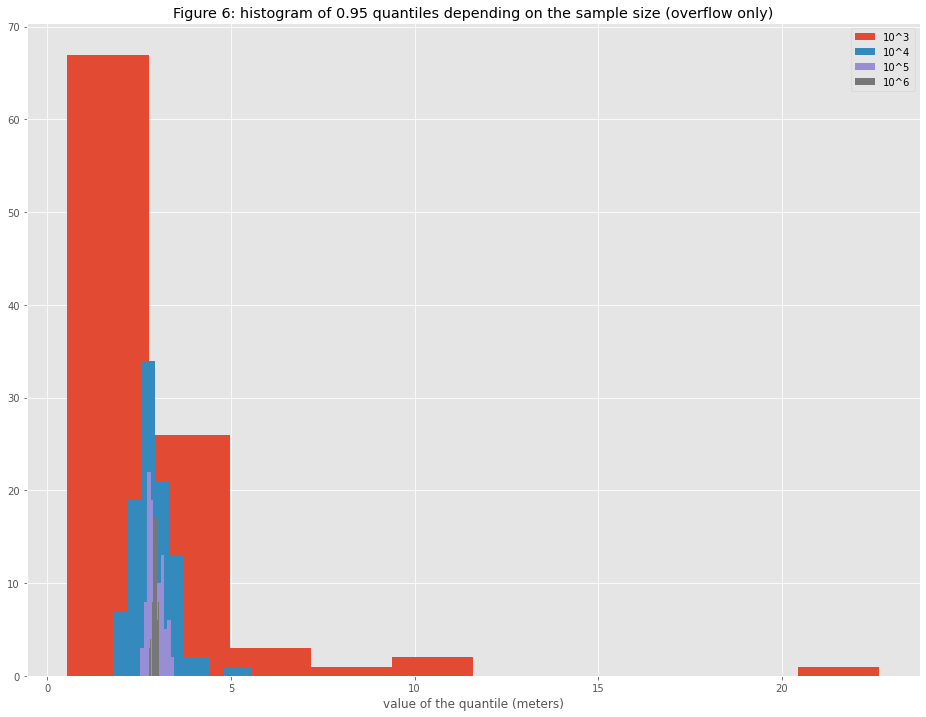

In [ ]:
ax=dfp3_95['value'].hist(label='10^3')
dfp4_95['value'].hist(label='10^4')
dfp5_95['value'].hist(label='10^5')
dfp6_95['value'].hist(label='10^6')

ax.set_xlabel('value of the quantile (meters)')
ax.set_title('Figure 6: histogram of 0.95 quantiles depending on the sample size (overflow only)')
ax.legend()

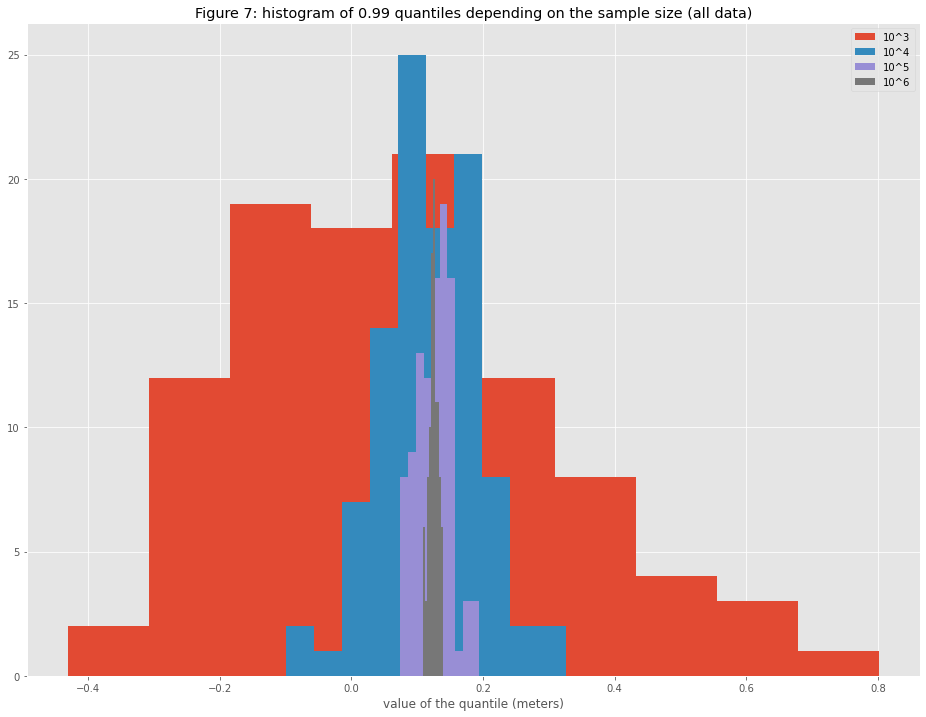

In [ ]:
ax=dfn3_99['value'].hist(label='10^3')
dfn4_99['value'].hist(label='10^4')
dfn5_99['value'].hist(label='10^5')
dfn6_99['value'].hist(label='10^6')

ax.set_xlabel('value of the quantile (meters)')
ax.set_title('Figure 7: histogram of 0.99 quantiles depending on the sample size (all data)')
ax.legend()


We can therefore conclude from these results that $10^6$ values is a good sample size and ensures consistent results because the quantile value will be very close to its mean. On the other hand, $10^3$ values for example is not enough to deal with the rare risks of overflow. Indeed, as shown in the histogram above, it can happen that for a simulation, the 95% quantile is about 20 meters, which would lead to build a 20 meters dyke to avoid 95% of the overflows (see red arrow on the above histogram). This would be a huge overestimate since the average quantile 95% is about 3 meters. We can see the importance of choosing and checking the size of the simulations to avoid misinterpretations that in real life could lead to overcosts or worse to a big underestimate of the risks. 




## 2.4 Extreme Value Theory

"*In statistics, the Fisher–Tippett–Gnedenko theorem (or the Extreme Value Theorem) is a general result in extreme value theory regarding asymptotic distribution of extreme order statistics. The maximum of a sample of iid random variables after proper renormalization can only converge in distribution to one of 3 possible distributions, the Gumbel distribution, the Fréchet distribution, or the Weibull distribution.*

*The role of the extremal types theorem for maxima is similar to that of central limit theorem for averages, except that the central limit theorem applies to the average of a sample from any distribution with finite variance, while the Fisher–Tippet–Gnedenko theorem only states that if the distribution of a normalized maximum converges, then the limit has to be one of a particular class of distributions. It does not state that the distribution of the normalized maximum does converge."*

The particular application of FTG Theorem and Extreme Value Analysis we will cover in this section is the "block maxima" method. The block maxima method directly extends the FTG theorem given above and the assumption is that each block forms a random iid sample from which an extreme value distribution can be fitted. So in other words, we will fit a Generalized Extreme Value distribution to the extrema sampled from each block.

In [ ]:
# Applying the block maxima method
S_df['simulation'] = S_df.index // 100

reduced_S = S_df[S_df['S'] == S_df.groupby('simulation')['S'].transform('max')]

To compute the distribution that fits better our data, we will use the same approach as in section 1.2.

##### P(EXTREME EVENT) = 1 - F(THRESHOLD) #####
dweibull  :  67.12947315099218 %
exponweib  :  67.29138864264763 %
frechet_r  :  59.4250409516782 %
gumbel_r  :  71.09109695341887 %
gumbel_l  :  42.98452076688272 %
invweibull  :  67.49219237670063 %
(0.19943315099462067, 0.9235834676472727)


Text(0, 0.5, 'Frequency')

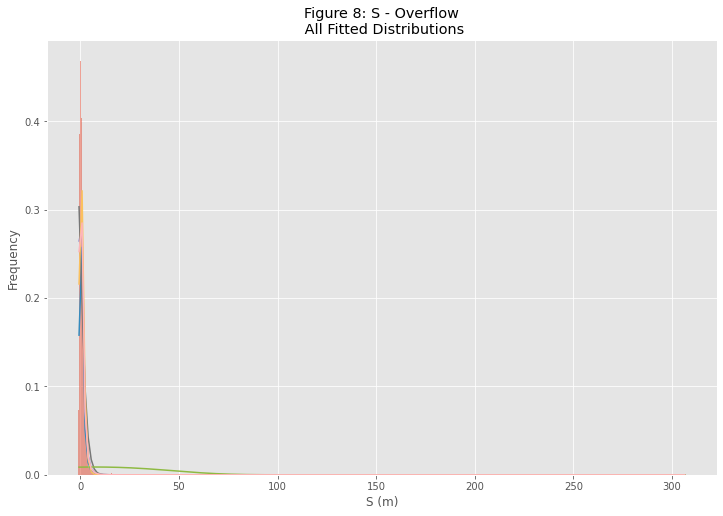

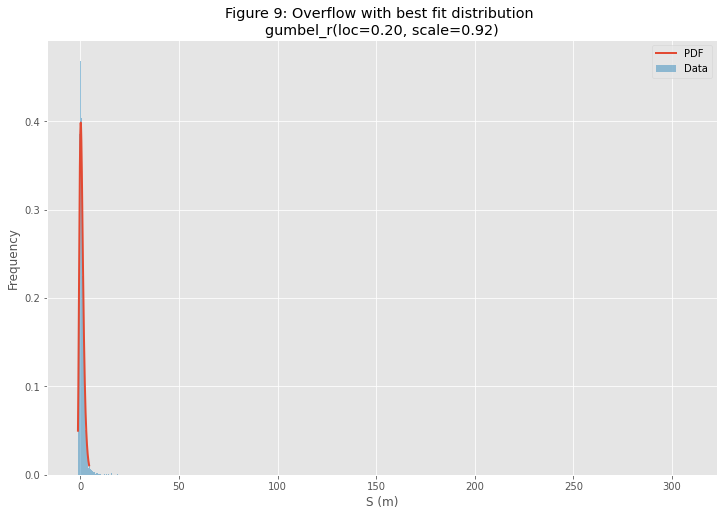

In [ ]:
# applying the FTG Theorem

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

print('##### P(EXTREME EVENT) = 1 - F(THRESHOLD) #####')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.dweibull,
        st.exponweib,
        st.frechet_r,
        st.gumbel_r,
        st.gumbel_l,
        st.invweibull
    ]

    # DISTRIBUTIONS = [st.gumbel_r, st.gumbel_l]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    results = {}

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass
                
                # print parameters and cdf for extreme events : P(S > THRESHOLD)
                cdf = distribution.cdf(0, loc=loc, scale=scale, *arg)

                results[distribution] = params

                print(distribution.name, ' : ', (1-cdf)*100, '%')

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params, results)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """
    print(params)
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data 
data = reduced_S['S']

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=1000, alpha=0.5, density=True, lw=2)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params, results = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_title(u'Figure 8: S - Overflow\n All Fitted Distributions')
ax.set_xlabel(u'S (m)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

weights = np.ones_like(data)/float(len(data))

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=1000, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Figure 9: Overflow with best fit distribution \n' + dist_str)
ax.set_xlabel(u'S (m)')
ax.set_ylabel('Frequency')

The first plot represents the histogram of our hydraulic model with all distributions.

The second plot represents the histogram with the distribution with the smallest SSE. For our case, we have an inverted Weibull distribution. 

The probability density function for an inverted Weibull distribution is: 

$ f(x) = c (\frac{x-loc}{scale})^{-c-1}\exp(-(\frac{x-loc}{scale})^{-c})$ 

An inverted Weibull distribution takes `c` as a shape parameter.

Note that shifting the location of a distribution does not make it a “noncentral” distribution

In our case, we have `c = 5.21`, `scale = 0.76` and `loc = -1.56`.

In [ ]:
threshold = [0, 1, 2, 3, 4, 5, 6, 7, 8]

def compute_extreme_event_probability(results, threshold, df=None):

    ls = []
    for distribution in results: 
        for t in threshold:
            
            params = results[distribution]

            arg = params[:-2]
            loc = params[-2]
            scale = params[-1]

            ls.append([distribution.name, t, round((1-distribution.cdf(t, loc=loc, scale=scale, *arg))*100, 4)])

    if not df:
        df = pd.DataFrame(ls, columns=['distribution', 'threshold', 'extreme_event_prob(%)'])

    return df

ev_prob = compute_extreme_event_probability(results, threshold)

print("Computing the probability of an extreme event according to the best fit distribution")
ev_prob[ev_prob.distribution == best_fit_name]

Computing the probability of an extreme event according to the best fit distribution


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `frechet_r` is deprecated!
The distribution `frechet_r` is a synonym for `weibull_min`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_min`.  For the Frechet distribution (i.e. the Type II
extreme value distribution), use `scipy.stats.invweibull`.
  from ipykernel import kernelapp as app


,distribution,threshold,extreme_event_prob(%)
27,gumbel_r,0,71.0911
28,gumbel_r,1,34.3145
29,gumbel_r,2,13.2673
30,gumbel_r,3,4.7062
31,gumbel_r,4,1.6193
32,gumbel_r,5,0.5514
33,gumbel_r,6,0.1871
34,gumbel_r,7,0.0634
35,gumbel_r,8,0.0215


Without a dike, the probability of overflow over a year is 68.69%.

In order to fulfill the 99% quantile, we need to build a dike of 5.94m.


In [ ]:
round(st.invweibull.ppf(0.99, c=5.21, loc=-4, scale=4.11), 2)

5.94

The extreme value theory has allowed us to refine the description of the distribution tail and to
readjust our risk prediction. Indeed, before this study we had obtained that to avoid 99% of the overflows it was necessary to build a 6.72 meter dike, now the height of the wall for this same risk is 5.94 meters.

To conclude, here is a summary of our approach for this part:

The use of the physical model allowed us to find a distribution for the overflow and thus to predict the risks by calculating some quantiles.
We realized that there was a significant difference with the results of the historical data approach.

Our first idea was to calculate a confidence interval on the quantiles and see if this deviation was due
to uncertainty. This approach did not permit to conclude but gave us the opportunity to check the
sensitivity of our simulation with respect to the sample size and so ensure the reliability of our
results. 

Finally we used the extreme value theory to refine our knowledge on the tail of the distribution and thus revise upwards the risks of severe overflow.


# 3. Third Approach: Determination of the dike height from the economic model

From the Extreme Value Theory, we find the best distribution for S considering the hydraulic model. We will now base on this distribution and determine a cost function in order to find a  hd  that minimizes the Economic risk associated with the overflow. For the Cost Function, we have:

$C_{t}(T) = C_{i}(h_{d}) + T \cdot  C_{m}(h_{d}) $ over duration $T$ 

$C_{d} = C_{s} + C_{g} = C_{s}(S) + C_{g}(S, h_{d}) $ for one year

$C_{c}(T) = C_{t}(T) + \sum_{j=1}^T C_{d,j}(S_{j}, h_{d}) $  over duration $T$ (j is the index of the year)

$C_{c, mean} = \frac{C_{c}(T)}{T} $ 


where we denote:



*   $S$ the overflow (in m), $Z_{d}$ the dike elevation (in m NGF) and $h_{d}$ the dike height (in m)
*   $C_{i}$ the  investment  cost  of  the  dam  for  a  given  height $h_{d}$  and  $C_{m}$  the  corresponding  annual 
maintenance cost
*   $C_{t}$  the  total  cost  of  the  dike  (investment  and  maintenance  accumulated  over  the  period considered) for a given height $h_{d}$, 
* $C_{s}$ the cost of damage to the site 
* $C_{g}$ the cost of damage to the dike, depending on the overflow $S$ and the investment cost $C_{i}$ (for 
one year) 
* $C_{d}$ the total cost of damage (for one year)
* $C_{c}$ the full cost, including, over a given period, investment/maintenance and damage costs to the 
dike and industrial facility, 
* $T$ the duration over which the problem is studied. 

**Table 3: Values used for overflow costs**

Overflow in relation to the dike S (m)  | Cost of damage $C_{s}$ to the site (M€) | Cost of damage $C_{s}$ to the dike (percentage of investment cost $C_{i}$)
-|-|-
-0.1      | 0 | 0%       
0      | 0 | 10%  
0.5      | 150 | 50%  
1      | 1500 | 100%  
1.5      | 2000 | 100%  
>2      | 2000 | 100%  




To start the simulation, we first transform the Table 3 in to continuous functions with relation to $h_{d}$ by fitting appropriate functions to the data:





In [ ]:
# Damage to the dike cost data
X_1 = np.array([0,.5,1]).reshape((-1, 1))
Y_1 = np.array([.1,.5,1])
model_cg = LinearRegression()
model_cg.fit(X_1,Y_1)

# Damage to the site cost data
X_2 = [0,.5,1,1.5,2]
Y_2_old = [0,150,1500,2000,2000]
Y_2 = [x / max(Y_2_old) for x in Y_2_old]
print(Y_2)

[0.0, 0.075, 0.75, 1.0, 1.0]


In [ ]:
# the damage cost to the dike may be modeled by a linear curve
def coef_cg(S,model):
  if S < 0:
    c_g = 0
  elif S < 1:
    S = S.reshape((-1, 1))
    c_g = model.predict(S)
  else:
    c_g = 1
  return c_g

# the damage cost to the dike may be modeled by a sigmoid
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)
p0 = [np.max(Y_2), np.median(X_2),1, np.min(Y_2)] # this is an mandatory initial guess
popt_sig, pcov_sig = curve_fit(sigmoid, X_2, Y_2,p0, method='dogbox')

def cs(S):
  from scipy.optimize import curve_fit

  if S<0:
    return 0
  else:
    y = sigmoid(S, *popt_sig)*max(Y_2_old)
    return y*(10**3)

X = np.linspace(0, 5, num=50)
Y_cg = []
Y_cs = []

for i in X:
  Y_cg.append(coef_cg(i,model_cg))
  Y_cs.append(cs(i))




/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


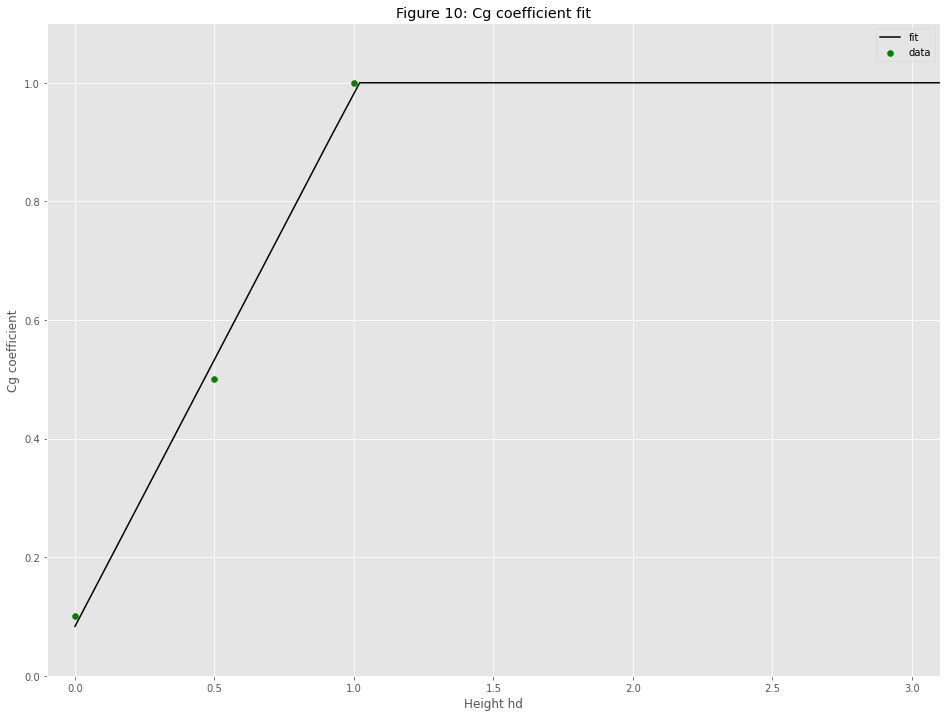

In [ ]:
#plot the damage cost to the dike coefficient
plt.plot(1, 2, 1)
plt.scatter(X_1, Y_1,color='g',label='data')
plt.plot(X, Y_cg,color='k',label='fit')
plt.legend(loc='best')
plt.xlabel('Height hd')
plt.ylabel('Cg coefficient')
plt.title('Figure 10: Cg coefficient fit')
plt.ylim([0, 1.1])
plt.xlim([-0.1, 3.1])
plt.show()

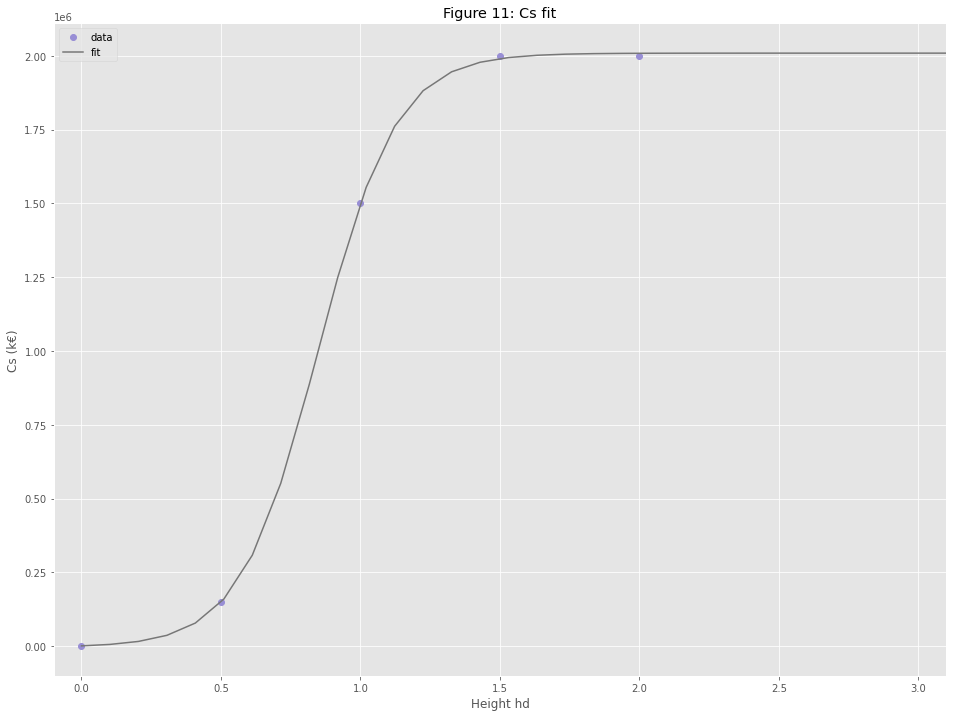

In [ ]:
# plot the damage cost to the site in case of overflow 
Y_2_plot = [x*(10**3) for x in Y_2_old]
plt.plot(1, 2, 2)
plt.plot(X_2, Y_2_plot, 'o', label='data')
plt.plot(X,Y_cs, label='fit')
plt.legend(loc='best')
plt.xlabel('Height hd')
plt.ylabel('Cs (k€)')
plt.title('Figure 11: Cs fit')
plt.xlim([-0.1, 3.1])
plt.show()

**Table 4: Values used for costs related to the construction and maintenance of the dike**

Height of the dike $h_{d}$ (m)  | Linear cost (€/m) | Length of the dike $l_{d}$ (m)  | Investment cost C_{i} (k€)
-|-|-|-
0 | - | - | -   
0.1 | 100 | 1000 | 100
0.5 | 150 | 1500 | 225
1 | 424 | 2437 | 1034
2 | 1200 | 3959 | 4750
3 | 2205 | 5000 | 11023
4 | 3394 | 5000 | 16971
5 | 4338 | 5000 | 21692
6 | 5302 | 5000 | 26509
7 | 6282 | 5000 | 31408
8 | 7275 | 5000 | 36377
9 | 8282 | 5000 | 41409
10 | 9300 | 5000 | 46498


Now we will fit a curve by parts for the investment costs, based on Table 4:

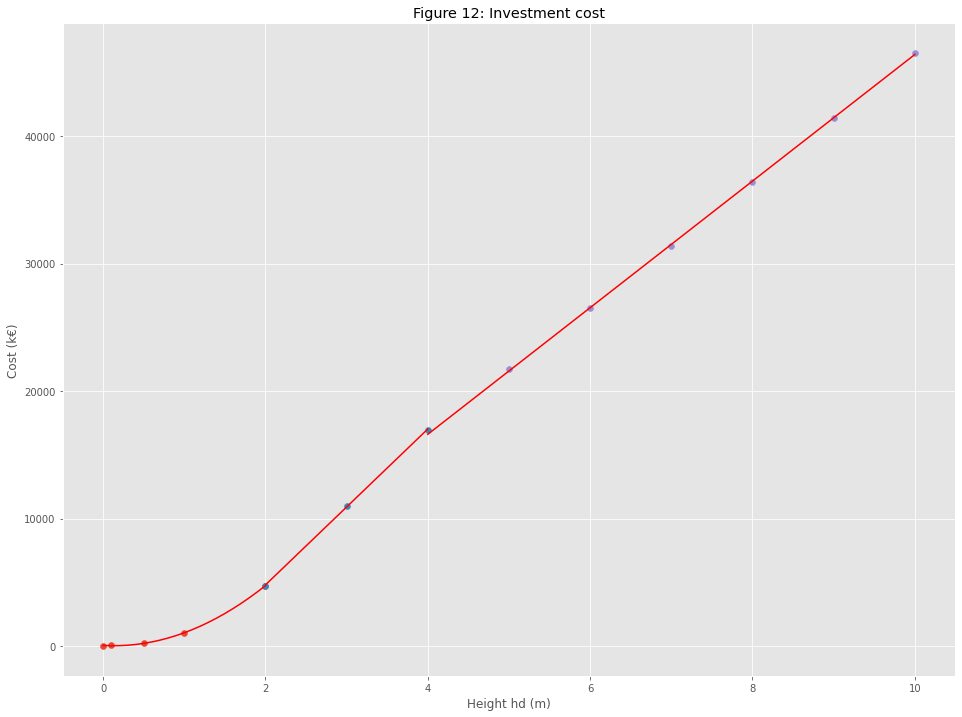

In [ ]:
#defining linear and quadratic functions
def lin_obj(x,a,b):
    return a * x + b

def quad_obj(x,a,b,c):
  return b * (x**2) + a * x + c

# taking the parameters based on table 2 
# and on the discretization of the data interval
hd_list_A=[0,0.1,0.5,1,2]
C_i_list_A=[0,100,225,1034,4750]
popt, _ = curve_fit(quad_obj, hd_list_A, C_i_list_A)
a, b, c= popt

hd_list_B=[2,3,4]
C_i_list_B=[4750,11023,16971]
popt, _ = curve_fit(lin_obj, hd_list_B, C_i_list_B)
d, e= popt

hd_list_C=[5,6,7,8,9,10]
C_i_list_C=[21692,26509,31408,36377,41409,46498]
popt, _ = curve_fit(lin_obj, hd_list_C, C_i_list_C)
f, g= popt


# Plotting the investment cost curve
plt.scatter(hd_list_A,C_i_list_A)
x_line=arange(np.min(hd_list_A),np.max(hd_list_A)+0.1,0.1)
y_line=quad_obj(x_line,a,b,c)
plt.plot(x_line,y_line,'-',color='red')

plt.scatter(hd_list_B,C_i_list_B)
x_line=arange(np.min(hd_list_B),np.max(hd_list_B)+1,1)
y_line=lin_obj(x_line,d,e)
plt.plot(x_line,y_line,'-',color='red')

plt.scatter(hd_list_C,C_i_list_C)
x_line=arange(np.min(hd_list_C)-1,np.max(hd_list_C)+1,1)
y_line=lin_obj(x_line,f,g)
plt.plot(x_line,y_line,'-',color='red')

plt.show
plt.xlabel('Height hd (m)')
plt.ylabel('Cost (k€)')
plt.title('Figure 12: Investment cost')

# taking investment values for the cost function considering variable hd's
def c_i(hd):
  if hd<0:
    C_i=0

  elif hd<2:
    C_i=quad_obj(hd,a,b,c)

  elif hd<4:
    C_i=lin_obj(hd,d,e)

  else:
    C_i=lin_obj(hd,f,g)

  return C_i
  

Finally we have all we need to define our cost function as follows:

In [ ]:
def cd(S,hd):
    C_g = c_i(hd)*coef_cg(S,model_cg)        # damage cost to the dike
    C_s = cs(S)                              # damage cost to the site
    C_dj = C_g + C_s                         # total damage cost (one year)
    return C_dj


def cost(hd,K,T):
  S = [(i - hd) for i in K]      # where K = Zv + H - Zb

  C_d_total = 0
  for j in range(T):
    C_d_total += cd(S[j],hd)       # total damage cost (thirty years)
  C_t = (1+T*0.01)*c_i(hd)         # construction and maintenance of the dike
  C_c = C_t + C_d_total            # total cost 
  C_c_mean = C_c/T                 # mean cost

  return C_c_mean

We may plot the cost function for a random $Z_v + H - Z_b$ as in Figure 13. We notice, though, that it's really variable depending on the occurrence or not of overflow

1968.300611722743 1.3226452905811623


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5, 1.0, 'Figure 13: Cost [k€] vs $h_d$ for a random $Z_v + H - Z_b$')

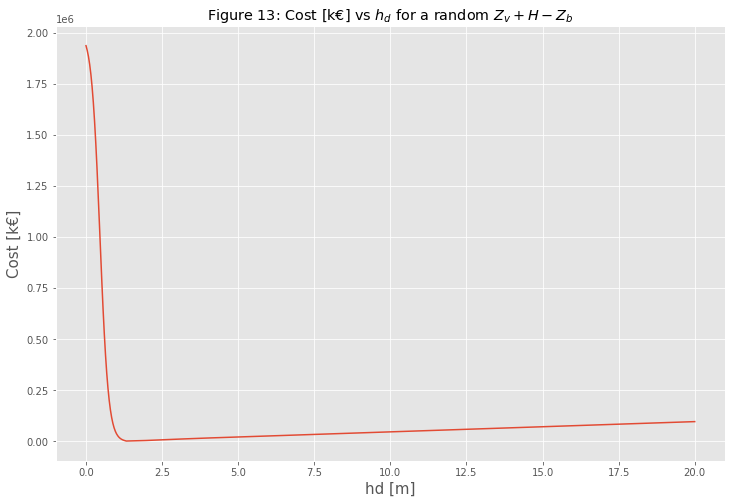

In [ ]:
l_costs=[]

S = st.invweibull.rvs(c=5.21, loc=-4, scale=4.11, size=1)
o = np.linspace(0,20,500)
min = np.inf
for k in range(len(o)):
  computed = cost(o[k],S,len(S))
  l_costs.append(computed)
  if computed < min:
    min_old = min
    min = computed 
i = l_costs.index(min)   
print(min,o[i])



plt.figure(figsize=(12,8))
plt.plot(o,l_costs)
plt.xlabel('hd [m]',fontsize=15)
plt.ylabel('Cost [k€]',fontsize=15)
plt.title('Figure 13: Cost [k€] vs $h_d$ for a random $Z_v + H - Z_b$')

Once we have the function of the costs defined, we can use a minimize method from scipy to find the value of $h_{d}$ that gives us the minimum costs. We take a 30 years sample to do so. Since the probability of having an overflow is not really high, we observe that sometimes no dike is required. That's why $10^4$ iterations are made, in order to find an empirical distribution of the $h_{d}$'s.

In [ ]:
# Defined by the challenge as a good order of magnitude to optimize the risk
T = 30 

tests = 10**4
lista_hd2 = []
lista_costs2 = []
o = np.linspace(0,20,500)
for k in range(tests):
  l_costs2 = []
  S = st.invweibull.rvs(c=5.21, loc=-4, scale=4.11, size=1)
  min = np.inf
  for k in range(len(o)):
    computed = cost(o[k],S,len(S))
    l_costs2.append(computed)
    if computed < min:
      min_old = min
      min = computed 
  i = l_costs2.index(min)
  # print(i)   
  # print(min,o[i])
  lista_hd2.append(o[i])
  lista_costs2.append(min)

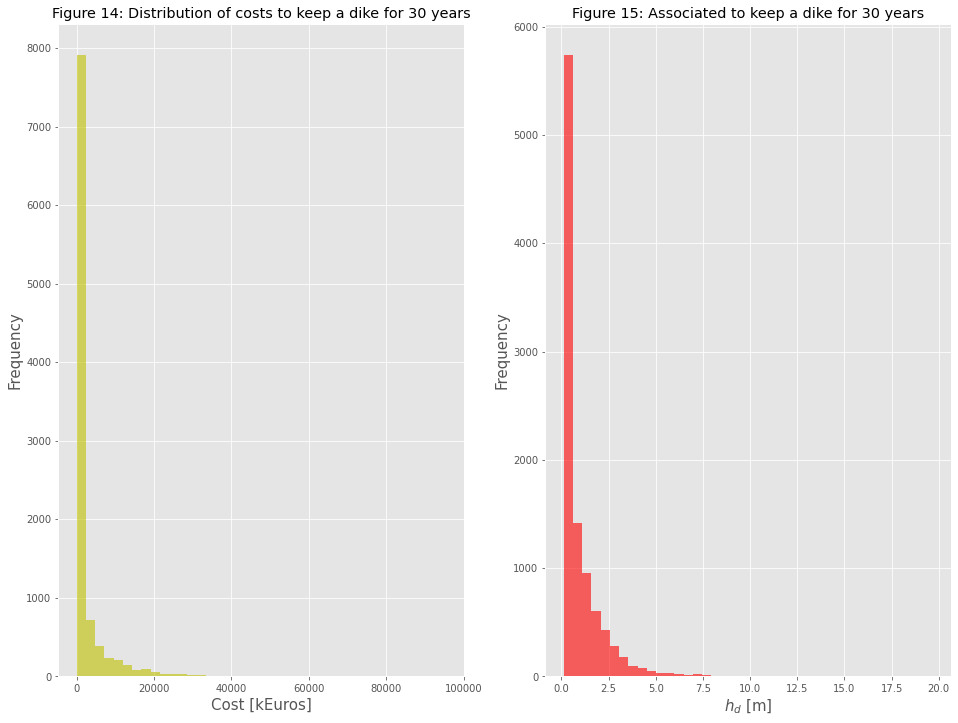

In [ ]:
binsize = 40
binsize2 = 40

plt.subplot(1, 2, 1)
plt.hist(lista_costs2, bins = binsize2, facecolor='y', alpha=0.6)
plt.xlabel(r'Cost [kEuros]',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Figure 14: Distribution of costs to keep a dike for 30 years')

plt.subplot(1, 2, 2)
plt.hist(lista_hd2, bins = binsize, facecolor='r', alpha=0.6)
plt.xlabel(r'$h_d$ [m]',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Figure 15: Associated to keep a dike for 30 years')

plt.show()

We may plot the histograms for the costs and the heights given 30 years analysis:

In [ ]:
print(np.quantile(lista_costs2,[0.95,0.995]))
print(np.quantile(lista_hd2,[0.95,0.99,0.995]))

[12545.07067797 33694.17560057]
[3.24649299 6.01202405 7.3747495 ]


We may see that the costs are usually more related to the construction and maintenance of the dike than to some damage. This happens because the overflow is considered a rare event. 

Even though, we notice that the height of the dike is similar to the one found through the other approaches: in order to fulfill the 1% quantile, we have $h_{d}$ around $6m $.

This is because the order of magnitude of an overflow damage is pretty much higher than the order of magnitude to build and keep a dike. So it worths building a relatively high dike in order to have less risk of deal with an overflow.

## 4. Conclusions

After simulating with the three models, we found that although using different approaches, they provide similar and coherent results.

**Table 5: Recap of the results**

Model  |  Risk   | $h_{d}$
-|-|-
Historical    | 1%  |   6.72
Hydraulic | 1% | 5.94
Economical    | 1% | 6.01

From the historical data, we were able to understand the empirical behavior of the river, even if the missing data limited the quality of the model.

The hydraulic model allowed the definition of a better distribution for $H$. Firstly, we tried to find $h_{d}$ based on the empirical distribution of the overflow $S$. We got lower values for $h_{d}$ when compared to historical data. Then, we realized that since we are dealing with rare events with a huge impact, it was very important to better study the **tail** of the distribution, which we did through the Extreme Value Theory (EVT). Using the EVT, we got $h_{d}$ that were more consistent compared to historical data.

Since the economical model is based on the hydraulic one, there results are similar. 

